# Neural Networks for Data Science Applications

## Lab session 4: Model building with an application to OCR

**Contents of the lab session**:
* Building CNNs with keras.Model and tf.layers.
* Effectively using the TensorBoard for debugging.
* Using Keras' ImageDataGenerator for handling datasets of images.
* Keras callbacks for checkpointing and TensorBoard.

## Virtual machine setup

In [0]:
# Enable the GPU runtime and restart the kernel
# Do it at the very beginning 

In [0]:
# The TensorFlow version currently available on Colab is the 1.15.0

# Install the new 2.0 version with GPU support
!pip install --quiet tensorflow-gpu==2.0.0

# < 400MB
# ignore the errors during the installation procedure

In [3]:
# Import TensorFlow and check the version
import tensorflow as tf
print(tf.__version__)

2.0.0


## Download the dataset

In [4]:
# Download the dataset from the "In Codice Ratio" website
!wget http://www.inf.uniroma3.it/db/icr/dataset_icr.zip
# < 5MB

--2020-01-26 21:53:25--  http://www.inf.uniroma3.it/db/icr/dataset_icr.zip
Resolving www.inf.uniroma3.it (www.inf.uniroma3.it)... 193.205.219.57
Connecting to www.inf.uniroma3.it (www.inf.uniroma3.it)|193.205.219.57|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9146769 (8.7M) [application/zip]
Saving to: ‘dataset_icr.zip.1’

dataset_icr.zip.1   100%[===================>]   8.72M  7.03MB/s    in 1.2s    

2020-01-26 21:53:27 (7.03 MB/s) - ‘dataset_icr.zip.1’ saved [9146769/9146769]



In [0]:
# Unzip the compressed file
!unzip -q dataset_icr.zip

In [6]:
# Have a look to the dataset main folder

!ls -1 dataset

# + We have a separate folder for each character
# + We have 23 classes
# + There are some duplicated letters (same letter, different shape) and a special "no_char" character

a
b
c
d_1
d_2
e
f
g
h
i
l
m
n
not_char
o
p
q
r
s_1
s_2
s_3
t
u


In [0]:
# If you want to read more about the project, check out the publications here:
# http://www.inf.uniroma3.it/db/icr/publications.html

## Load the dataset

In [0]:
import tensorflow as tf

In [0]:
# Generate batches of images with real-time data augmentation
# Define the abstract image generator
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=5, # up to ±5 degrees
                                                                  width_shift_range=0.05, # up to ±5% of the image
                                                                  height_shift_range=0.05, # up to ±5% of the image
                                                                  rescale=1.0/255, # convert from uint [0, 255] to float [0.0, 1.0]
                                                                  validation_split=0.2) # 20% of the samples for the validation set

# You can also make a more flexible (and more complex) solution using tf.data

In [10]:
# Define the specific data generator for our images
train_data_gen = image_generator.flow_from_directory(directory='dataset',
                                                     subset='training',                                                  
                                                     batch_size=32,
                                                     shuffle=True,
                                                     target_size=(56, 56))

Found 18400 images belonging to 23 classes.


In [11]:
test_data_gen = image_generator.flow_from_directory(directory='dataset',
                                                    subset='validation',                                                  
                                                    batch_size=32,
                                                    shuffle=False,
                                                    target_size=(56, 56))

Found 4600 images belonging to 23 classes.


## Look at the dataset

> "Become one with the data"  
> Andrej Karpathy

(rule n. 1 of [A Recipe for Training Neural Networks](https://karpathy.github.io/2019/04/25/recipe/))

image shape: (56, 56)


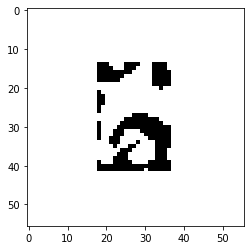

In [12]:
# Plot one (original) image
import matplotlib.pyplot as plt
image = plt.imread('./dataset/a/1.png')
print('image shape:', image.shape)
plt.imshow(image, cmap='gray')

label (one-hot encoded): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


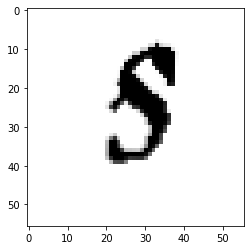

In [13]:
# Plot one (augmented) image
import matplotlib.pyplot as plt
# next iterator returns the first batch
x_batch, y_batch = next(train_data_gen)
# take the first image of the batch (which has in total 32 images)
image = x_batch[0]
# y has 23 labels, with the 1 in correspondance of the class of the image
label_one_hot = y_batch[0] # one-hot encoded
plt.imshow(image)
print('label (one-hot encoded):', label_one_hot)

In [14]:
# dimensioni del primo elemento del primo batch, ovvero della prima immagine del batch
x_batch[0].shape

(56, 56, 3)

In [15]:
# dimension of the first batch: 
# number of images = 32
# image dimensions= 56x56x3
print(x_batch.shape)
# Note: Channel last

(32, 56, 56, 3)


In [16]:
import numpy as np
# dictionary of classes
class_dictionary = train_data_gen.class_indices
# take the label key corresponding to our image
label = list(class_dictionary.keys())[np.argmax(label_one_hot)]
print('label:', label)

label: s_2


## Download a CNN from keras.applications

In [17]:
# Download a pretrained neural network
from tensorflow.keras import applications
vgg = applications.vgg16.VGG16(weights='imagenet')

vgg.summary()

# ImageNet images are 224x224x3 images belonging to 1000 classes
# VGG: Oxford Visual Geometry Group

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [18]:
vgg = applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(56, 56, 3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 56, 56, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 56, 56, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 56, 56, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 28, 28, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 28, 28, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 28, 28, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 14, 14, 128)       0     

In [0]:
# Make all the layers not trainable
for layer in vgg.layers:
    layer.trainable = False

In [20]:
vgg.summary()
# Non-trainable parameters: 14714688

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 56, 56, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 56, 56, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 56, 56, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 28, 28, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 28, 28, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 28, 28, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 14, 14, 128)       0     

In [0]:
from tensorflow.keras import models, layers

def build_model():
  model = models.Sequential()
  # use the pretrained network as a feature extractor (not trainable)
  model.add(vgg)
  # add a linear classifier (single layer, trainable) on top of it
  model.add(layers.Flatten())
  model.add(layers.Dense(23, activation='softmax'))
  # define loss, optimizer and metric for the model
  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  return model

In [22]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 23)                11799     
Total params: 14,726,487
Trainable params: 11,799
Non-trainable params: 14,714,688
_________________________________________________________________


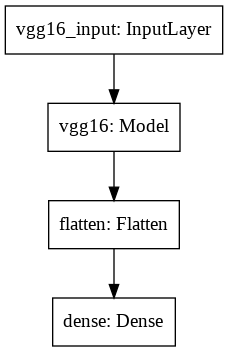

In [23]:
tf.keras.utils.plot_model(model)

## Basic fine-tuning (linear classifier only)

In [24]:
# train model
history = model.fit_generator(train_data_gen, epochs=10, shuffle=True)

# ~1.5 minutes for each epoch
# Very inefficient computing strategy. Why?
# Loss is decreasing, accuracy is increasing. What about overfitting?
# Train loss curve only at the end VS while the training is running

Epoch 1/10
575/575 [==============================] - 45s 78ms/step - loss: 2.2754 - accuracy: 0.4566
Epoch 2/10
575/575 [==============================] - 43s 74ms/step - loss: 1.5522 - accuracy: 0.6214
Epoch 3/10
575/575 [==============================] - 42s 74ms/step - loss: 1.3010 - accuracy: 0.6657
Epoch 4/10
575/575 [==============================] - 43s 74ms/step - loss: 1.1637 - accuracy: 0.6883
Epoch 5/10
575/575 [==============================] - 43s 75ms/step - loss: 1.0716 - accuracy: 0.7085
Epoch 6/10
575/575 [==============================] - 43s 75ms/step - loss: 0.9982 - accuracy: 0.7279
Epoch 7/10
575/575 [==============================] - 43s 75ms/step - loss: 0.9496 - accuracy: 0.7397
Epoch 8/10
575/575 [==============================] - 43s 74ms/step - loss: 0.9086 - accuracy: 0.7487
Epoch 9/10
575/575 [==============================] - 43s 75ms/step - loss: 0.8740 - accuracy: 0.7540
Epoch 10/10
575/575 [==============================] - 42s 74ms/step - loss: 0.842

Text(0, 0.5, 'accuracy')

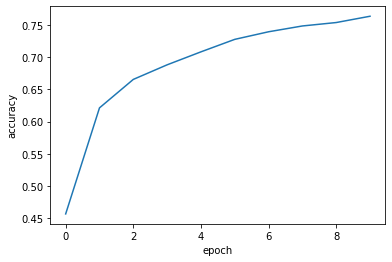

In [25]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [26]:
# test model
model.evaluate(test_data_gen)

144/144 [==============================] - 8s 53ms/step - loss: 0.8316 - accuracy: 0.7576


[0.83155224720637, 0.7576087]

## Checkpointing

In [0]:
# Let's start again from the beginning
model = build_model()

In [0]:
from tensorflow.keras import callbacks
# Save the model after every epoch.
checkpoint_callback = callbacks.ModelCheckpoint(filepath='./checkpoints/model-{epoch:02d}.ckpt', 
                                                save_weights_only=True,
                                                save_freq='epoch',
                                                verbose=1)

In [29]:
# train
model.fit_generator(train_data_gen,
                    epochs=10,
                    shuffle=True,
                    callbacks=[checkpoint_callback])

Epoch 1/10
574/575 [============================>.] - ETA: 0s - loss: 2.2633 - accuracy: 0.4532
Epoch 00001: saving model to ./checkpoints/model-01.ckpt
575/575 [==============================] - 43s 75ms/step - loss: 2.2625 - accuracy: 0.4535
Epoch 2/10
574/575 [============================>.] - ETA: 0s - loss: 1.5540 - accuracy: 0.6259
Epoch 00002: saving model to ./checkpoints/model-02.ckpt
575/575 [==============================] - 43s 75ms/step - loss: 1.5539 - accuracy: 0.6258
Epoch 3/10
574/575 [============================>.] - ETA: 0s - loss: 1.2982 - accuracy: 0.6690
Epoch 00003: saving model to ./checkpoints/model-03.ckpt
575/575 [==============================] - 43s 75ms/step - loss: 1.2981 - accuracy: 0.6690
Epoch 4/10
574/575 [============================>.] - ETA: 0s - loss: 1.1637 - accuracy: 0.6933
Epoch 00004: saving model to ./checkpoints/model-04.ckpt
575/575 [==============================] - 43s 75ms/step - loss: 1.1634 - accuracy: 0.6934
Epoch 5/10
574/575 [====

In [30]:
!ls ./checkpoints

checkpoint			   model-06.ckpt.data-00000-of-00002
model-01.ckpt.data-00000-of-00002  model-06.ckpt.data-00001-of-00002
model-01.ckpt.data-00001-of-00002  model-06.ckpt.index
model-01.ckpt.index		   model-07.ckpt.data-00000-of-00002
model-02.ckpt.data-00000-of-00002  model-07.ckpt.data-00001-of-00002
model-02.ckpt.data-00001-of-00002  model-07.ckpt.index
model-02.ckpt.index		   model-08.ckpt.data-00000-of-00002
model-03.ckpt.data-00000-of-00002  model-08.ckpt.data-00001-of-00002
model-03.ckpt.data-00001-of-00002  model-08.ckpt.index
model-03.ckpt.index		   model-09.ckpt.data-00000-of-00002
model-04.ckpt.data-00000-of-00002  model-09.ckpt.data-00001-of-00002
model-04.ckpt.data-00001-of-00002  model-09.ckpt.index
model-04.ckpt.index		   model-10.ckpt.data-00000-of-00002
model-05.ckpt.data-00000-of-00002  model-10.ckpt.data-00001-of-00002
model-05.ckpt.data-00001-of-00002  model-10.ckpt.index
model-05.ckpt.index


In [31]:
latest_checkpoint = tf.train.latest_checkpoint('./checkpoints')
print(latest_checkpoint)

./checkpoints/model-10.ckpt


## Load previous checkpoints

In [32]:
model = build_model() # start again from skratch
model.evaluate(test_data_gen)

# - Trained feature extractor (on ImageNet)
# - Untrained linear classifier

144/144 [==============================] - 8s 55ms/step - loss: 3.3678 - accuracy: 0.0337


[3.367844039367305, 0.033695653]

In [33]:
# start again the model
model = build_model()
# load the optimal wights from the last checkpoint 
# on this way it's not necessary the training
model.load_weights(latest_checkpoint)
# test model
model.evaluate(test_data_gen)

# - Trained feature extractor (on ImageNet)
# - Trained linear classifier (on In Codice Ratio)

144/144 [==============================] - 8s 54ms/step - loss: 0.8382 - accuracy: 0.7570


[0.8382429906891452, 0.7569565]

## TensorBoard

In [0]:
model = build_model()

In [0]:
!pip install tensorboard==2.0.0

In [36]:
import tensorboard
print(tensorboard.__version__)

2.0.0


In [0]:
%load_ext tensorboard
#%reload_ext tensorboard

In [0]:
logdir = './logs'

In [0]:
%tensorboard --logdir=$logdir
#!kill 3510

In [0]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, update_freq='batch')#10

In [0]:
history = model.fit(train_data_gen, epochs=10, shuffle=True, validation_data=test_data_gen, callbacks=[checkpoint_callback, tensorboard_callback])

In [0]:
#!rm -r ./logs/*

In [0]:
#vgg = applications.vgg16.VGG16(include_top=False, input_shape=(56, 56, 3), weights=None)

In [0]:
shrinked_vgg = models.Sequential([layers.InputLayer(input_shape=(56, 56, 3)), 
                                  *vgg.layers[0:6], 
                                  layers.MaxPool2D(pool_size=(5, 5)), 
                                  layers.Flatten(), 
                                  layers.Dense(23, activation='softmax')])

In [0]:
shrinked_vgg.summary()

In [0]:
# Make all the layers trainable
for layer in shrinked_vgg.layers:
    layer.trainable = True

shrinked_vgg.summary()

In [0]:
shrinked_vgg.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

In [0]:
history = shrinked_vgg.fit(train_data_gen, 
                           epochs=10, 
                           shuffle=True, 
                           validation_data=test_data_gen, 
                           callbacks=[checkpoint_callback, tensorboard_callback])


In [0]:
# Homework: define a proper architecture and try to reach the highest possible validation accuracy